In [1]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt

import appletree as apt
from appletree import randgen
from appletree import Parameter
from appletree import Likelihood
from appletree.share import DATAPATH, PARPATH
from appletree.components import *

In [2]:
apt.set_gpu_memory_usage(0.2)

# Define parameters

In [3]:
par_manager = Parameter(os.path.join(PARPATH, 'apt_sr0_er.json'))

# Define likelihood

In [4]:
config = dict(
    data_file_name = os.path.join(apt.DATAPATH, 'data_XENONnT_Rn220_v8_strax_v1.2.2_straxen_v1.7.1_cutax_v1.9.0.csv'),
    bins_type = 'equiprob',
    bins_on = ['cs1', 'cs2'],
    bins = [15, 15],
    x_clip = [0, 100],
    y_clip = [2e2, 1e4],
)
llh = Likelihood(**config)

In [5]:
llh.register_component(AC, 'rn220_ac')
llh.register_component(ERBand, 'rn220_er')
llh.print_likelihood_summary(short=True)


BINNING

    bins_type: equiprob
    bins_on: ['cs1', 'cs2']

DATA

    file_name: /home/xudc/appletree/appletree/data/data_XENONnT_Rn220_v8_strax_v1.2.2_straxen_v1.7.1_cutax_v1.9.0.csv
    data_rate: 2058.0

MODEL

    COMPONENT 0: rn220_ac
        type: fixed
        rate_par: ac_rate
        pars: ['ac_rate']

    COMPONENT 1: rn220_er
        type: simulation
        rate_par: er_rate
        pars: ['drift_velocity', 'er_rate', 'fano', 'field', 'g1', 'g2', 'gas_gain', 'nex_ni_ratio', 'p_dpe', 'py0', 'py1', 'py2', 'py3', 'py4', 'rf0', 'rf1', 's2_threshold', 'w']



In [6]:
llh.get_log_likelihood?

Signature: llh.get_log_likelihood(key, batch_size, parameters)
Docstring: <no docstring>
File:      ~/appletree/appletree/likelihood.py
Type:      method


# Define posterior

In [7]:
def log_posterior(pars, batch_size=int(1e6)):
    par_manager.set_parameter_fit_from_array(pars)
    
    key = randgen.get_key()
    key, log_likelihood = llh.get_log_likelihood(key, batch_size, par_manager.get_all_parameter())
    log_prior = par_manager.log_prior
    
    return log_likelihood + log_prior

In [8]:
log_posterior(par_manager.parameter_fit_array)

541.5253355096947

# Fit

In [9]:
import emcee

In [10]:
nwalkers = 200
ndim = len(par_manager.parameter_fit_array)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

p0 = []
for _ in range(nwalkers):
    par_manager.sample_init()
    p0.append(par_manager.parameter_fit_array)
    
_ = sampler.run_mcmc(p0, 100, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.79s/it]


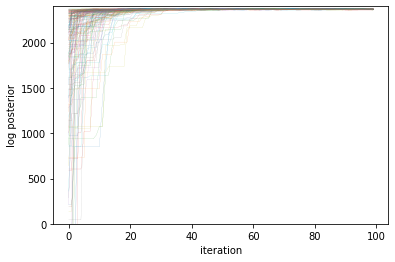

In [11]:
logp = sampler.get_log_prob()

for _logp in logp.T:
    plt.plot(_logp, lw=0.1)

plt.ylim(0, 2400)
plt.xlabel('iteration')
plt.ylabel('log posterior')
plt.show()